In [8]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data1Path = r'../dataset/data2a.txt'
data1Label = r'../dataset/data2alabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

In [9]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

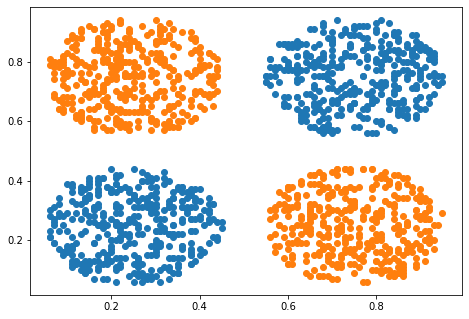

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [4]:
from IPython.display import Image

# Loss function Two-Qubit

Loss is calculated with a simple two-qubit gate. First, the data is embedded into Rx rotation with pi/4 rotation of Ry and Rz. The parameterized quantum circuit is placed after the embedding. We used same structure of the circuit1 from the paper to check the convergence.

![Two-Qubits Example](Two-qubits.png)

In [11]:
#load the simulation functcions from the quantumcircuit.py file

from quantumcircuit import *
loss2qubit([0.5,0.5],-1,[0,0,0,-5])

2

## [SPSA method](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation)

SPSA is an algorithm used in numerical optimization.

Consider a loss function $L(\mathbf{x})$. In order to optimize $L$, SPSA iteratively optimizes the parameters of the loss function according to the following update rule:

$$\mathbf{y}_{n+1} = \mathbf{y}_{n} - a_{n}\widehat{\Delta L}_{n}(\mathbf{y}_{n}),$$

where $\widehat{\Delta L}_{n}(\mathbf{y}_{n}))$ is an estimate of the gradient at $\mathbf{y}_{n}$.

How SPSA calculates that gradient is by using a finite-difference rule on random perturbations of component of the parameter vector.
    $$\left( \widehat{\Delta L}_{n}(\mathbf{y}_{n}))\right)_{j} = \frac{L(\mathbf{y}_{n} + c_{n}\boldsymbol{\Delta}_{n}) - L(\mathbf{y}_{n} - c_{n}\boldsymbol{\Delta}_{n}) }{c_{n}\left(\boldsymbol{\Delta}_{n}\right)_{j}}$$
    
That is at each iteration, SPSA generates a random perturbation $\boldsymbol{\Delta}_{n}$, and does a finite-difference rule with that perturbation.

In order for the algorithm to converge, the random perturbation $\boldsymbol{\Delta}_{n}$ and finite-difference coefficients $c_{n}$ must satisfy certain properties (see the Wikipedia article linked to in the title). Importantly $c_{n}$ must tend to 0 as $n$ increases, and the size of the random fluctuations $\boldsymbol{\Delta}_{n}$ must also be bounded.

According to the wikipedia article, the coefficients $a_{n}$ and $c_{n}$ should look something like

$$c_{n} = \frac{c}{n^\gamma}~~\text{and}~~a_{n} = \frac{a}{n}.$$

In [12]:
#load the SPSA optimizer from the optimizer.py file
from optimizer import *

# Test the convergence of 100 data point

To have sanity check, we take 100 data and run the optimization.

In [13]:
c = 1
a = 1

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(1)
currentParams = pi*np.random.uniform(size=4)
for j in range(300):      
    
    cj = c/(j+1)**(1/3)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss2qubit(data[j][0],data[j][1],currentParams) for j in data_ixs])/len(data_ixs) + .05*np.linalg.norm(x[:2])**2
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([quick_predict(data[j][0],currentParams) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 1.2818706253493541 Accuracy = 0.53
1 th iteration L= 0.8219279778928419 Accuracy = 0.67
2 th iteration L= 0.6190052631857667 Accuracy = 0.74
3 th iteration L= 0.5385666917617715 Accuracy = 0.81
4 th iteration L= 0.46902583649447754 Accuracy = 0.8
5 th iteration L= 0.4219099138049142 Accuracy = 0.84
6 th iteration L= 0.3582866492435719 Accuracy = 0.8
7 th iteration L= 0.3343356067277126 Accuracy = 0.84
8 th iteration L= 0.33125096101647983 Accuracy = 0.84
9 th iteration L= 0.3282994369355844 Accuracy = 0.88
10 th iteration L= 0.3067127535956116 Accuracy = 0.89
11 th iteration L= 0.285381530503686 Accuracy = 0.86
12 th iteration L= 0.2838945131420447 Accuracy = 0.89
13 th iteration L= 0.28261019305422236 Accuracy = 0.87
14 th iteration L= 0.24089636450099 Accuracy = 0.89
15 th iteration L= 0.21993873742431913 Accuracy = 0.88
16 th iteration L= 0.23934350985859432 Accuracy = 0.88
17 th iteration L= 0.1985694172449247 Accuracy = 0.92
18 th iteration L= 0.21809957541344477

150 th iteration L= 0.2459332445755415 Accuracy = 0.89
151 th iteration L= 0.24591612804600357 Accuracy = 0.87
152 th iteration L= 0.26589921394530874 Accuracy = 0.9
153 th iteration L= 0.22588249857372658 Accuracy = 0.85
154 th iteration L= 0.24589080609133585 Accuracy = 0.85
155 th iteration L= 0.26592395202211394 Accuracy = 0.89
156 th iteration L= 0.26588275133579403 Accuracy = 0.88
157 th iteration L= 0.22589105712165258 Accuracy = 0.89
158 th iteration L= 0.2658993517560187 Accuracy = 0.86
159 th iteration L= 0.24588326566620214 Accuracy = 0.87
160 th iteration L= 0.24589156752767727 Accuracy = 0.89
161 th iteration L= 0.24589985803822498 Accuracy = 0.91
162 th iteration L= 0.26588406697365885 Accuracy = 0.91
163 th iteration L= 0.2658923628871681 Accuracy = 0.87
164 th iteration L= 0.24590064728948496 Accuracy = 0.86
165 th iteration L= 0.2658614465055486 Accuracy = 0.86
166 th iteration L= 0.2658697608623389 Accuracy = 0.9
167 th iteration L= 0.24585458602264565 Accuracy = 0.89

298 th iteration L= 0.28478748321811415 Accuracy = 0.85
299 th iteration L= 0.28476900391455584 Accuracy = 0.86


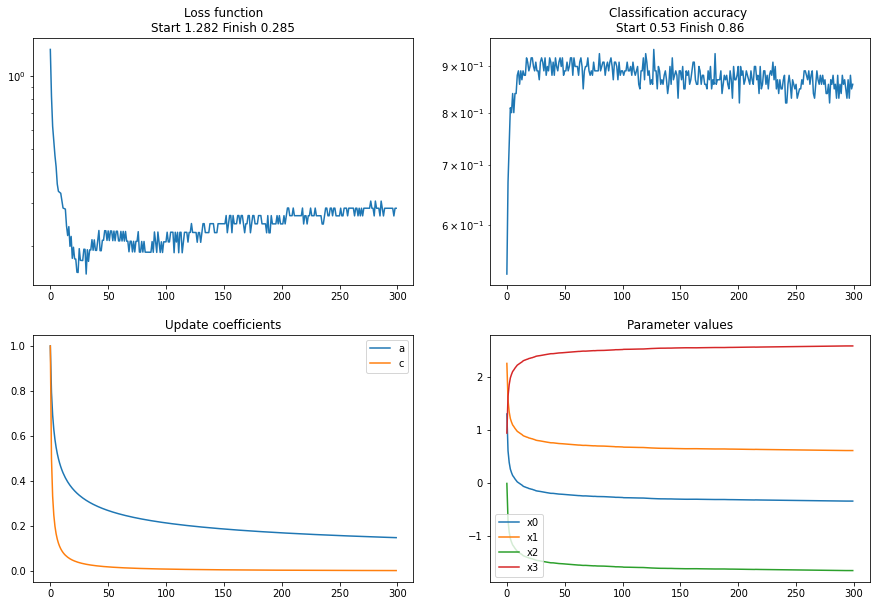

In [14]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

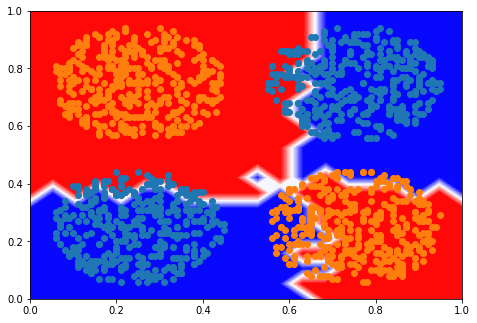

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = quick_predict( np.array([X[k], X[j]]),currentParams)
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# Test the convergence of 300 data point

To have sanity check, we take first data and run the optimization.

In [ ]:
c = 1
a = 1

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(1)
currentParams = pi*np.random.uniform(size=4)
for j in range(300):      
    
    cj = c/(j+1)**(1/2.1)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=300)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss2qubit(data[j][0],data[j][1],currentParams) for j in data_ixs])/len(data_ixs) + .05*np.linalg.norm(x[:2])**2
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([quick_predict(data[j][0],currentParams) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 1.2752039586826875 Accuracy = 0.5
1 th iteration L= 0.7776002826090527 Accuracy = 0.6633333333333333
2 th iteration L= 0.649568871537475 Accuracy = 0.75
3 th iteration L= 0.5573769765003675 Accuracy = 0.7933333333333333
4 th iteration L= 0.4749518356450273 Accuracy = 0.79
5 th iteration L= 0.4412830128192729 Accuracy = 0.8366666666666667
6 th iteration L= 0.4166129404059455 Accuracy = 0.8133333333333334
7 th iteration L= 0.393112477598299 Accuracy = 0.8233333333333334
8 th iteration L= 0.3896790066269553 Accuracy = 0.8266666666666667
9 th iteration L= 0.38045843378253325 Accuracy = 0.8366666666666667
10 th iteration L= 0.3716877174043949 Accuracy = 0.8266666666666667
11 th iteration L= 0.33641611227136375 Accuracy = 0.8533333333333334
12 th iteration L= 0.2809630014490552 Accuracy = 0.8633333333333333
13 th iteration L= 0.26623597361168505 Accuracy = 0.8733333333333333
14 th iteration L= 0.2655538569970106 Accuracy = 0.85
15 th iteration L= 0.25149528865176285 Accurac

132 th iteration L= 0.3118363067158559 Accuracy = 0.8566666666666667
133 th iteration L= 0.30515479668797035 Accuracy = 0.86
134 th iteration L= 0.31180681908400876 Accuracy = 0.88
135 th iteration L= 0.2984590364474791 Accuracy = 0.8566666666666667
136 th iteration L= 0.3051272711065005 Accuracy = 0.8666666666666667
137 th iteration L= 0.3050817194499746 Accuracy = 0.86
138 th iteration L= 0.30506792205705985 Accuracy = 0.85
139 th iteration L= 0.3051164470136042 Accuracy = 0.8666666666666667
140 th iteration L= 0.29173834734425363 Accuracy = 0.8633333333333333
141 th iteration L= 0.31167912638661244 Accuracy = 0.86


In [ ]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = quick_predict( np.array([X[k], X[j]]),currentParams)
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

 # Test the convergence of 1500 data point

To have sanity check, we take first data and run the optimization.

In [ ]:
c = 1
a = 1

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(1)
currentParams = pi*np.random.uniform(size=4)
for j in range(100):      
    
    cj = c/(j+1)**(1/2.1)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=1500)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss2qubit(data[j][0],data[j][1],currentParams) for j in data_ixs])/len(data_ixs)+ 0.05*np.linalg.norm(x[:2])**2
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([quick_predict(data[j][0],currentParams) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=20)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = quick_predict( np.array([X[k], X[j]]),currentParams)
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)